In [1]:
import numpy as np
from scipy.linalg import expm
from tqdm.auto import trange

/Users/visanim/work/random-markov-field/metabolite_inference/model_validation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_rate_matrix(alpha: float) -> np.ndarray:
    if alpha > 1 or alpha < 0:
        raise ValueError("alpha must be between 0 and 1.")

    return np.array([[-alpha, alpha], [1 - alpha, alpha - 1]])

In [3]:
def calculate_P_matrix(
    rate_matrix: np.ndarray,
    log_nu: float,
    branch_length: float,
) -> np.ndarray:
    return expm(rate_matrix * branch_length * np.exp(log_nu))

In [4]:
# Function to simulate data
def simulate_data(alpha: float, log_nu: float, num_leaves: int, branch_length):
    root_state = np.random.choice([0, 1], p=[1 - alpha, alpha])
    P = calculate_P_matrix(create_rate_matrix(alpha), log_nu, branch_length)
    leaves = np.random.choice([0, 1], size=num_leaves, p=P[root_state])
    return root_state, leaves

In [5]:
# Likelihood function
def log_likelihood(
    alpha: float,
    root_state: int,
    leaves: np.ndarray,
    log_nu: float,
    branch_length: float,
):
    if alpha <= 0 or alpha >= 1:
        return -np.inf
    P = calculate_P_matrix(create_rate_matrix(alpha), log_nu, branch_length)
    return np.sum(np.log(P[root_state, leaves]))

In [6]:
# MCMC to infer alpha with adaptive step size
def mcmc_infer_alpha(
    root_state,
    leaves,
    log_nu,
    branch_length,
    num_samples=10000,
    target_acceptance=0.4,
    adapt_interval=100,
):
    branch_length = 1 / len(leaves)
    alpha = np.random.uniform(0.0001, 0.999999)  # Initial alpha
    samples = []
    log_prob = log_likelihood(alpha, root_state, leaves, log_nu, branch_length)
    step_size = 0.5
    acceptances = 0

    for i in trange(num_samples, leave=False):
        new_alpha = alpha + np.random.uniform(-step_size, step_size)
        if new_alpha < 0:
            new_alpha = np.abs(new_alpha)
        if new_alpha > 1:
            new_alpha = 2 - new_alpha

        new_log_prob = log_likelihood(
            new_alpha, root_state, leaves, log_nu, branch_length
        )

        if np.log(np.random.rand()) < new_log_prob - log_prob:
            alpha, log_prob = new_alpha, new_log_prob
            acceptances += 1

        samples.append(alpha)

        # Adjust step size every adapt_interval steps
        # if (i + 1) % adapt_interval == 0:
        # acceptance_rate = acceptances / adapt_interval
        # if acceptance_rate < target_acceptance:
        # step_size *= 0.9
        # else:
        # step_size *= 1.1
        # acceptances = 0

    # print("Average acceptance: ", acceptances / num_samples)
    return np.array(samples)

In [7]:
# Simulate data and run MCMC
true_alpha = 0.5
num_leaves = 600
log_nu = 0.5  # + np.log(1000 / 60)
branch_length = 1 / num_leaves
root_state, leaves = simulate_data(true_alpha, log_nu, num_leaves, branch_length)

samples = mcmc_infer_alpha(root_state, leaves, log_nu, branch_length, num_samples=20000)

In [8]:
print(sum(leaves) / len(leaves), "are 1.")

0.0016666666666666668 are 1.


In [9]:
calculate_P_matrix(
    create_rate_matrix(true_alpha), log_nu=log_nu, branch_length=1 / num_leaves
)

array([[0.99862795, 0.00137205],
       [0.00137205, 0.99862795]])

In [10]:
print("Mean alpha : ", np.mean(samples[-1000:]))

Mean alpha :  0.5535081658240816


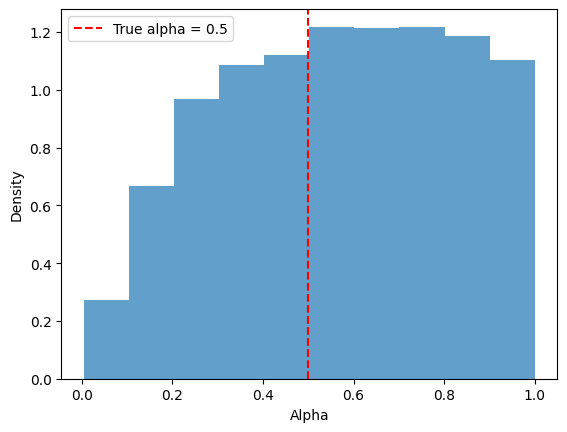

In [11]:
import matplotlib.pyplot as plt

# Plot results
plt.hist(samples, density=True, alpha=0.7)
plt.axvline(
    true_alpha,
    color="r",
    linestyle="dashed",
    label=f"True alpha = {true_alpha}",
)
plt.xlabel("Alpha")
plt.ylabel("Density")
plt.legend()
plt.show()

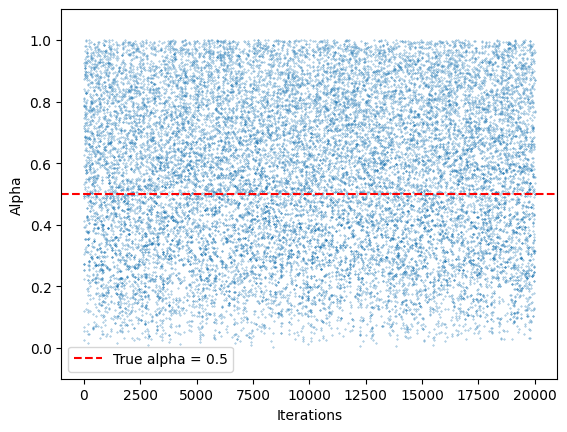

In [12]:
plt.scatter(x=range(len(samples)), y=samples, s=0.1, alpha=0.7)
plt.axhline(
    true_alpha, color="r", linestyle="dashed", label=f"True alpha = {true_alpha}"
)
plt.ylim(-0.1, 1.1)
plt.ylabel("Alpha")
plt.xlabel("Iterations")
plt.legend()
plt.show()

In [13]:
branch_length

0.0016666666666666668

In [14]:
# simulate many times with same prior values
# infer
# calculate the
ls = []
root_states = []
number_of_ones = []

# Simulate data and run MCMC
for _ in trange(139):
    root_state, leaves = simulate_data(true_alpha, log_nu, num_leaves, branch_length)
    number_of_ones.append(sum(leaves))
    root_states.append(root_state)

    samples = mcmc_infer_alpha(
        root_state, leaves, log_nu, branch_length, num_samples=50000
    )

    ls.append(sum(samples < true_alpha) / len(samples))

100%|██████████| 139/139 [01:32<00:00,  1.51it/s]


(-0.1, 1.1)

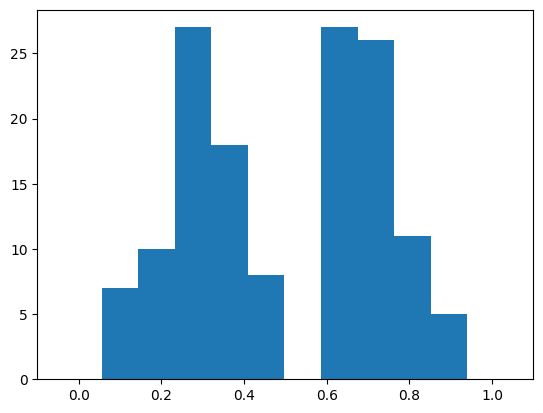

In [15]:
plt.hist(ls)
plt.xlim(-0.1, 1.1)

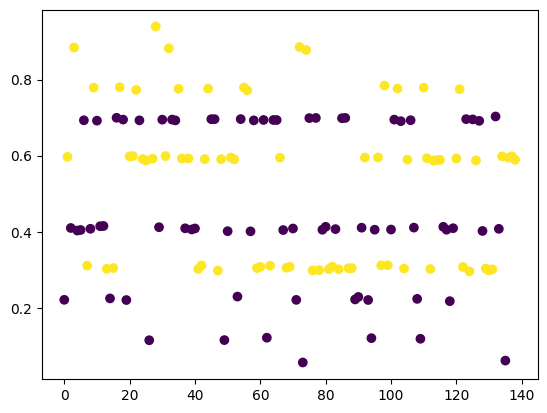

In [16]:
plt.scatter(x=range(len(ls)), y=ls, c=root_states)

In [18]:
np.mean(root_states)

np.float64(0.5035971223021583)

In [17]:
calculate_P_matrix(create_rate_matrix(true_alpha), log_nu, branch_length) * num_leaves

array([[599.17677095,   0.82322905],
       [  0.82322905, 599.17677095]])